Stable diffusion with negative prompts in midjourney style.

A [Hugging Face](https://huggingface.co) login is needed in order to download Stable Diffusion.

In [ ]:
!nvidia-smi

Sun Sep 17 14:45:38 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install -qq diffusers["torch"] transformers
!pip install -qq "ipywidgets>=7,<8"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 9.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 31.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 35.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 51.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 72.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 10.8 MB/s eta 0:00:00


In [ ]:
from diffusers import StableDiffusionPipeline, EulerAncestralDiscreteScheduler
import torch
from PIL import Image
import os
from transformers import CLIPTextModel, CLIPTokenizer
from huggingface_hub import notebook_login, hf_hub_url
import requests

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [ ]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols
    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

The following cell downloads the `<wrong>` token to be used in a negative prompt:

In [ ]:
if not os.path.exists("midjourney.bin"):
    token_url=hf_hub_url(repo_id="minimaxir/wrong_embedding_sd_2_0",
                        filename="learned_embeds.bin")
    r = requests.get(token_url)
    open('wrong.bin', 'wb').write(r.content)

    token_url=hf_hub_url(repo_id="minimaxir/midjourney_sd_2_0",
                        filename="learned_embeds.bin")
    r = requests.get(token_url)
    open('midjourney.bin', 'wb').write(r.content)

In [ ]:
notebook_login()

In [ ]:
model_id = "stabilityai/stable-diffusion-2-base"
tokenizer = CLIPTokenizer.from_pretrained(model_id, subfolder="tokenizer", use_auth_token=True,)
text_encoder = CLIPTextModel.from_pretrained(model_id, subfolder="text_encoder", use_auth_token=True)
vocab_size = tokenizer.vocab_size

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1727: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:2363: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


In [ ]:
def load_learned_embed_in_clip(learned_embeds_path, text_encoder, tokenizer, token=None):
  loaded_learned_embeds = torch.load(learned_embeds_path, map_location="cpu")

  # separate token and the embeds
  trained_token = list(loaded_learned_embeds.keys())[0]
  embeds = loaded_learned_embeds[trained_token]

  # cast to dtype of text_encoder
  dtype = text_encoder.get_input_embeddings().weight.dtype
  embeds.to(dtype)

  # add the token in tokenizer
  token = token if token is not None else trained_token
  num_added_tokens = tokenizer.add_tokens(token)
  if num_added_tokens == 0:
    raise ValueError(f"The tokenizer already contains the token {token}. Please pass a different `token` that is not already in the tokenizer.")

  # resize the token embeddings
  text_encoder.resize_token_embeddings(len(tokenizer))

  # get the id for the token and assign the embeds
  token_id = tokenizer.convert_tokens_to_ids(token)
  text_encoder.get_input_embeddings().weight.data[token_id] = embeds

  print(trained_token)

In [ ]:
embed_paths = [
    "wrong.bin",
    "midjourney.bin"
]

for embed in embed_paths:
    load_learned_embed_in_clip(embed, text_encoder, tokenizer)

You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 49409. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc
You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 49410. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


<wrong>
<midjourney>


In [ ]:
scheduler = EulerAncestralDiscreteScheduler.from_pretrained(model_id, subfolder="scheduler")
pipe = StableDiffusionPipeline.from_pretrained(model_id,
                                               scheduler=scheduler,
                                               text_encoder=text_encoder,
                                               tokenizer=tokenizer,
                                               revision="fp16",
                                               torch_dtype=torch.float16,
                                               safety_checker=None).to("cuda")

unet/diffusion_pytorch_model.safetensors not found


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
def latents_generator(seed=0):
    g = torch.Generator(device='cuda')
    g.manual_seed(seed)

    latent_shape = (pipe.unet.in_channels,
                    512 // pipe.vae_scale_factor,
                    512 // pipe.vae_scale_factor)
    latent = torch.randn(latent_shape, generator=g, device="cuda")
    latent_batched = torch.repeat_interleave(latent.unsqueeze(0), 2, dim=0).to('cuda')
    return g, latent_batched

In [ ]:
def prompt_builder(keys, prompt_dict):
    return_dict = {"prompt": prompt_dict["original"],
                   "negative_prompt": ""}
    for key in keys:
        if key == "original":
            break
        else:
            if "pos" in key:
                return_dict["prompt"] += f", {prompt_dict[key]}"
            elif "neg" in key:
                return_dict["negative_prompt"] = prompt_dict[key]
    return return_dict

In [129]:
last_ctr = 0
ctr = last_ctr+1
seed = 19687
# best seed: 19687
# backup seeds: 19683, 19685
base_prompt = "black short sleeve crewneck crop top"

pos_prompt = "hyper-detailed and intricate, white background, realistic shaded, fine detail, realistic proportions, symmetrical, sharp focus, 8K resolution"
pos_token = "in the style of <midjourney>"
neg_prompt = "person, woman, man, pant, body"
neg_token = "in the style of <wrong>"

prompt_dict = {
    "original": base_prompt,
    "pos_prompt": pos_prompt,
    "pos_token": pos_token,
    "neg_prompt": neg_prompt,
    "neg_token": neg_token,

}
g, latent_batched = latents_generator(seed)

grid_order=[
    ["pos_prompt", "neg_prompt"],
    ["pos_token", "neg_prompt"],
    ["pos_prompt", "neg_token"],
    ["pos_token", "neg_token"]
]

<ipython-input-13-ddfe7ba50f23>:5: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latent_shape = (pipe.unet.in_channels,


In [130]:
for row in range(len(grid_order)):
  key_lists = grid_order[row]
  prompt_dicts = [prompt_builder(x, prompt_dict) for x in key_lists]
  prompts = [x["prompt"] for x in prompt_dicts]
  negative_prompts = [x["negative_prompt"] for x in prompt_dicts]
  with torch.autocast("cuda"):
      g.manual_seed(seed)
      images = pipe(prompt=prompts,
                    negative_prompt=negative_prompts,
                    latents=latent_batched,
                    generator=g,
                    num_inference_steps=50, guidance_scale=7.5)["images"][0]
      images.save(f"result_img_{ctr}.png")
      last_ctr += 1
      break

  0%|          | 0/50 [00:00<?, ?it/s]

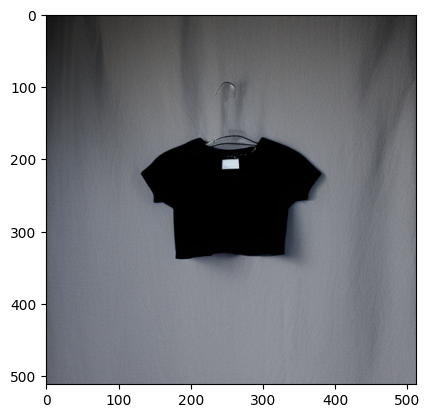

In [131]:
image = Image.open(f"/content/result_img_{ctr}.png")
img = np.array(image).astype(np.uint8)
plt.imshow(img)

# Clothing segmentation

In [ ]:
from transformers import SegformerImageProcessor, AutoModelForSemanticSegmentation
import cv2
import numpy as np
from PIL import Image
import requests
import matplotlib.pyplot as plt
import torch.nn as nn

processor = SegformerImageProcessor.from_pretrained("mattmdjaga/segformer_b2_clothes")
model = AutoModelForSemanticSegmentation.from_pretrained("mattmdjaga/segformer_b2_clothes")

/usr/local/lib/python3.10/dist-packages/transformers/models/segformer/image_processing_segformer.py:101: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


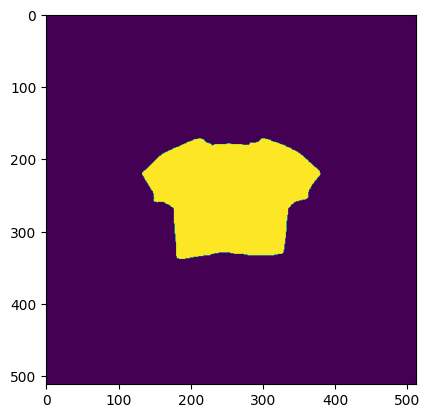

In [132]:
inputs = processor(images=image, return_tensors="pt")
outputs = model(**inputs)
logits = outputs.logits.cpu()

upsampled_logits = nn.functional.interpolate(
    logits,
    size=image.size[::-1],
    mode="bilinear",
    align_corners=False,
)

pred_seg = upsampled_logits.argmax(dim=1)[0]
pred_seg = pred_seg.numpy()
plt.imshow(pred_seg)

In [134]:
np.unique(pred_seg)

array([0, 7])

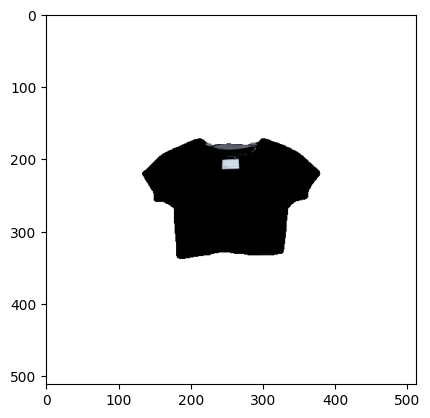

In [137]:
mask = np.equal(pred_seg, 4).astype(np.uint8)
if not np.sum(mask):
  mask = np.equal(pred_seg, 7).astype(np.uint8)
mask = cv2.GaussianBlur(mask,(7,7),0)
mask = cv2.threshold(mask, 5, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]
kernel = np.ones((7, 7), np.uint8)
closing = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=1)
mask = cv2.threshold(mask, 5, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]
mask = mask//255
fgnd_mask=(mask==1)
result = np.ones_like(img).astype(np.uint8)*255
result[fgnd_mask] = img[fgnd_mask]
Image.fromarray(result).save(f"result_img{ctr}_out.png")
plt.imshow(result)